In [ ]:
import numpy as np
import pandas as pd
import tensorflow
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Dropout, TimeDistributed
import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
energy_url = 'https://raw.githubusercontent.com/EurousZhao/Group-1/main/data/energy_dataset.csv'
weather_url = 'https://raw.githubusercontent.com/EurousZhao/Group-1/main/data/weather_features.csv'
df_energy = pd.read_csv(energy_url)
df_weather = pd.read_csv(weather_url)

In [ ]:
df_energy = df_energy.drop(["generation fossil coal-derived gas","generation fossil oil shale", "generation fossil peat", "generation geothermal", "generation marine", "generation wind offshore" ,"generation hydro pumped storage aggregated", "forecast wind offshore eday ahead", "generation hydro pumped storage aggregated", "forecast wind offshore eday ahead"], axis= 1)

In [ ]:
# convert categorical variables to factors

df_weather["weather_main"],weather_main = pd.factorize(df_weather["weather_main"])
df_weather["weather_description"],weather_main = pd.factorize(df_weather["weather_description"])
df_weather["weather_icon"],weather_main = pd.factorize(df_weather["weather_icon"])


In [ ]:
# Convert time to datetime object and set it as index

df_energy['time'] = pd.to_datetime(df_energy['time'], utc=True, infer_datetime_format=True)
df_energy = df_energy.set_index('time')

In [ ]:
df_weather['time'] = pd.to_datetime(df_weather['dt_iso'], utc=True, infer_datetime_format=True)
df_weather = df_weather.drop(['dt_iso'], axis=1)
df_weather = df_weather.set_index('time')

In [ ]:
to_convert = ['pressure', 'humidity', 'wind_speed', 'wind_deg', 'clouds_all', 'weather_id']

for column in to_convert:
    df_weather[column] = df_weather[column].astype(float)

In [ ]:
# remove duplicates so data matches

cities = df_weather['city_name'].unique()
grouped_weather = df_weather.groupby('city_name')
print(df_energy.shape[0])
for city in cities:
    print(grouped_weather.get_group(city).shape[0])


for city in cities:
    print(df_weather.groupby('city_name').get_group(city).shape[0])

35064
35145
36267
35951
35476
35557
35145
36267
35951
35476
35557


In [ ]:
df_energy = df_energy.interpolate("linear")
df_weather = df_weather.interpolate("linear")

In [ ]:
type(df_energy)

pandas.core.frame.DataFrame

In [ ]:
df_1, df_2, df_3, df_4, df_5 = [x for _, x in df_weather.groupby('city_name')]
dfs = [df_1, df_2, df_3, df_4, df_5]

In [ ]:
df_final = df_energy

for df in dfs:
    city = df['city_name'].unique()
    city_str = str(city).replace("'", "").replace('[', '').replace(']', '').replace(' ', '')
    df = df.add_suffix('_{}'.format(city_str))
    df_final = df_final.merge(df, on=['time'], how='outer')
    df_final = df_final.drop('city_name_{}'.format(city_str), axis=1)


In [ ]:
df_energy = df_energy.resample('D').max()
df_final = df_final.resample('D').max()

In [ ]:
df_final = df_final.drop(['price actual'], axis = 1)

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))

df_scaled = scaler.fit_transform(df_final)

In [ ]:
price_actual = df_energy.filter(["price actual"])
#price_actual = price_actual[(len(df_scaled) - 500):len(df_scaled)]
df_price = price_actual.values
#df_price = df_price[(len(df_scaled) - 500):len(df_scaled)]
price_scaled = scaler.fit_transform(df_price)

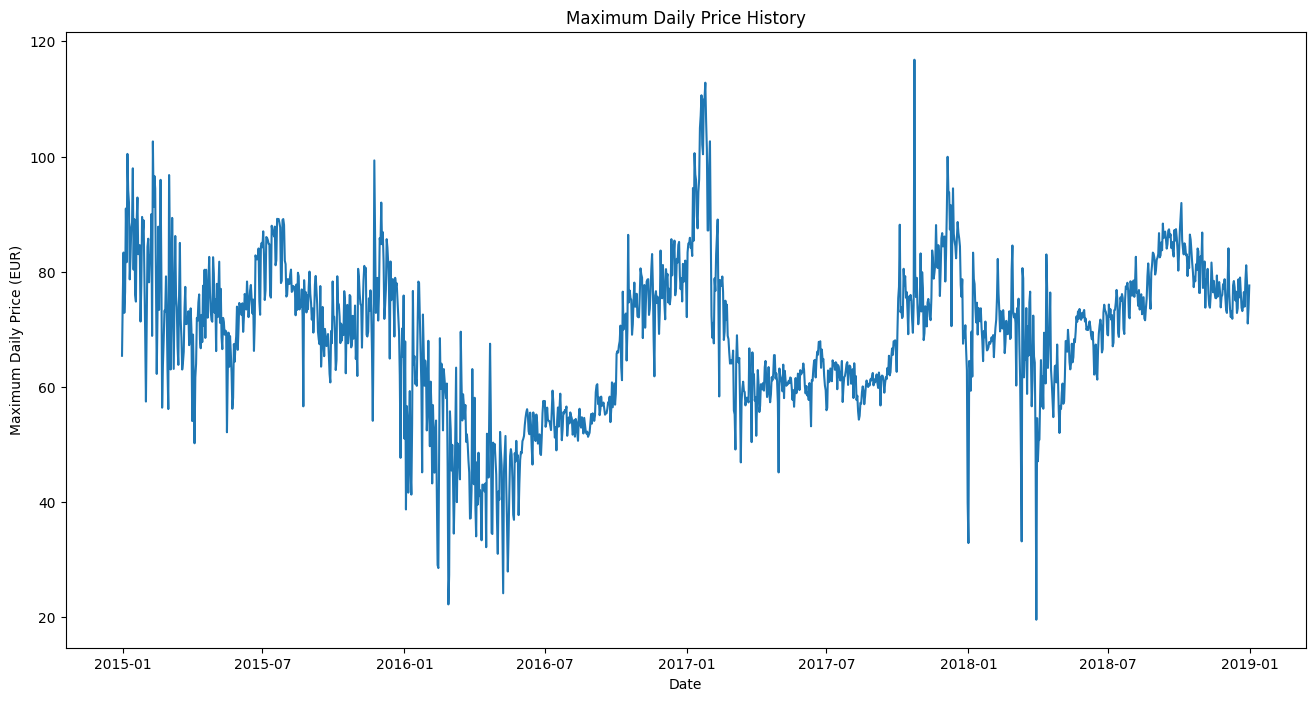

In [ ]:
# Visualise price

plt.figure(figsize =(16,8))
plt.title("Maximum Daily Price History")
plt.plot(price_actual)
plt.xlabel("Date")
plt.ylabel("Maximum Daily Price (EUR)")
plt.show()

Splitting the data set into train and test sets using random shuffling and sampling works well for independent and identically distributed (i.i.d) data sets. However, this is not appropriate for time series data since the order of each observation matters. Future observations depend on past observations and splitting the data randomly can lead to information leakage, as future data might end up in the training set.

Therefore, we split the data based on a specific time point i.e. we take the first 3 years as the train set and the remaining 25% as the test set.

In [ ]:
def timeseries_split(X, y, test_size=0.2, random_state = 42):
  np.random.seed(random_state)

  tr_len = math.ceil(len(X)*(1-test_size))
  training_data = X[0:tr_len]

  X_train = []
  y_train = []

  k = 60 # number of previous observations to predict next one

  for i in range(k, len(training_data)):
      # In each pass, the first k observations are added to X_train,  the k+1th observation is added to y_train

      X_train.append(training_data[i-k:i, 0])
      y_train.append(training_data[i, 0])

  test_data = X[tr_len - k:, :]

  X_test = []
  y_test = y[tr_len: , :]

  for i in range(k, len(test_data)):
    X_test.append(test_data[i-k:i, 0])

  return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)


In [ ]:

# def timeseries_split(X, y, test_size, past_history, prediction_size, random_state=42):
#     np.random.seed(random_state)

#     tr_len = math.ceil(len(X) * (1 - test_size))
#     training_data = X[0:tr_len]

#     X_train = []
#     y_train = []

#     for i in range(past_history, len(training_data)):
#         # In each pass, the first 'past_history' observations are added to X_train,
#         # the 'past_history+prediction_size' observations are added to y_train

#         X_train.append(training_data[i - past_history:i, 0])
#         y_train.append(training_data[i:i + prediction_size, 0])

#     test_data = X[tr_len - past_history:, :]

#     X_test = []
#     y_test = y[tr_len:, :]

#     for i in range(past_history, len(test_data)):
#         X_test.append(test_data[i - past_history:i, 0])

#     return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [ ]:
X_train, X_test, y_train, y_test = timeseries_split(df_scaled, df_price, test_size = 0.2, random_state = 42 )

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

In [ ]:
X_train.shape, X_test.shape , y_train.shape, y_test.shape

((1110, 60, 1), (292, 60, 1), (1110,), (292, 1))

## Time Distributed MLP Model

In [ ]:
multivariate_mlp = tf.keras.models.Sequential([
    TimeDistributed(Dense(200, activation='relu'),
                    input_shape=(X_train.shape[1], 1)),
    TimeDistributed(Dense(150, activation='relu')),
    TimeDistributed(Dense(100, activation='relu')),
    TimeDistributed(Dense(50, activation='relu')),
    Flatten(),
    Dense(150, activation='relu'),
    Dropout(0.1),
    Dense(1)
])


In [ ]:
multivariate_mlp.compile(optimizer = "adam", loss = "mean_squared_error")

In [ ]:
np.random.seed(5)
multivariate_mlp.fit(X_train, y_train, batch_size = 1, epochs = 1)

1110/1110 [==============================] - 9s 7ms/step - loss: 0.0226


In [ ]:
np.random.seed(5)
mlp_predictions = multivariate_mlp.predict(X_test)
mlp_predictions = scaler.inverse_transform(mlp_predictions)

# rmse
rmse = np.sqrt(np.mean(mlp_predictions - y_test)**2)
print("Root mean squared error:", rmse)

10/10 [==============================] - 0s 12ms/step
Root mean squared error: 8.57643744481753


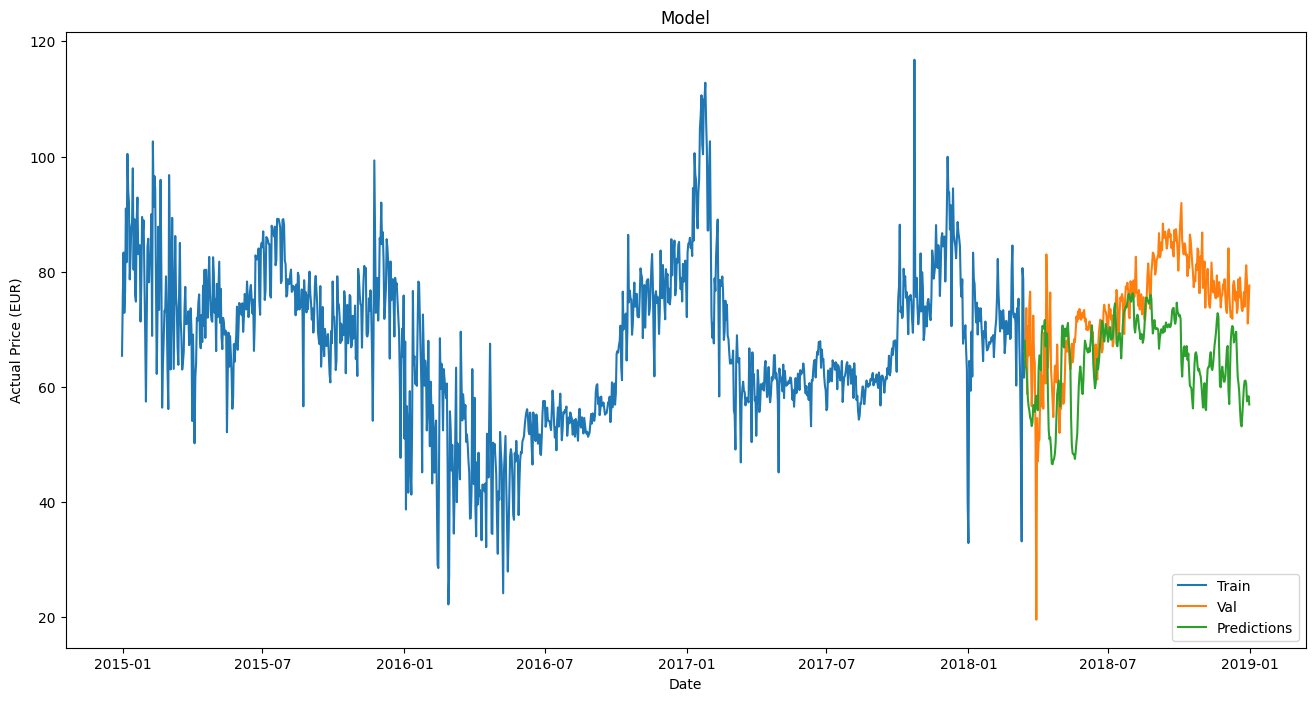

In [ ]:
# plot predictions
tr_len = math.ceil(len(df_scaled)*(1-0.2))
train = price_actual[:tr_len]
valid = price_actual[tr_len:]
valid["Predictions"] = mlp_predictions


plt.figure(figsize = (16,8))
plt.title("Model")
plt.xlabel("Date")
plt.ylabel("Actual Price (EUR)")
plt.plot(train["price actual"])
plt.plot(valid[["price actual", "Predictions"]])
plt.legend(["Train", "Val", "Predictions"], loc="lower right")
plt.show()

## TSMixer MLP Model

In [ ]:

def res_block(inputs, norm_type, activation, dropout, ff_dim):
    """Residual block of TSMixer."""

    norm = (
      layers.LayerNormalization
      if norm_type == 'L'
        else layers.BatchNormalization
    )

    # Temporal Linear
    x = norm(axis=[-2, -1])(inputs)
    x = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Channel, Input Length]
    x = layers.Dense(x.shape[-1], activation=activation)(x)
    x = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Input Length, Channel]
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feature Linear
    x = norm(axis=[-2, -1])(res)
    x = layers.Dense(ff_dim, activation=activation)(
      x
    )  # [Batch, Input Length, FF_Dim]
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1])(x)  # [Batch, Input Length, Channel]
    x = layers.Dropout(dropout)(x)
    return x + res


def build_model(
    input_shape,
    pred_len,
    norm_type,
    activation,
    n_block,
    dropout,
    ff_dim,
    target_slice,
):
    """Build TSMixer model."""

    inputs = tf.keras.Input(shape=input_shape)
    x = inputs  # [Batch, Input Length, Channel]
    for _ in range(n_block):
      x = res_block(x, norm_type, activation, dropout, ff_dim)

    if target_slice:
     x = x[:, :, target_slice]

    x = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Channel, Input Length]
    x = layers.Dense(pred_len)(x)  # [Batch, Channel, Output Length]
    outputs = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Output Length, Channel])

    return tf.keras.Model(inputs, outputs)

In [ ]:
tsmix = build_model(input_shape = (X_train.shape[1], 1),
    pred_len = 1,
    norm_type = 'L',
    activation = 'relu',
    n_block = 2,
    dropout = 0.1,
    ff_dim = 150,
    target_slice = False)
tsmix.compile(optimizer = "adam", loss = "mean_squared_error")
tsmix.fit(X_train, y_train, batch_size = 1, epochs = 1)

  69/1110 [>.............................] - ETA: 3s - loss: 1.7583

## Hyperparameter Tuning

### Rolling Forecast Origin K-Folds Cross Validation

In [ ]:
# Custom rolling origin cross validation function

def rolling_origin_Kfolds(X_train, y_train, k):
  k = k+1
  p = math.ceil(len(X_train)/k)

  for i in range(1,k):
    idx = p*i
    cv_X_train = X_train[:idx]
    cv_y_train = y_train[:idx]

    cv_X_test = X_train[idx:idx + p]
    cv_y_test = y_train[idx:idx + p]

    yield cv_X_train, cv_X_test, cv_y_train, cv_y_test


In [ ]:
# visualise cv train/test lengths

cv_rolling = rolling_origin_Kfolds(X_train, y_train, k = 5)

i = 0
for cv_X_train, cv_X_test, cv_y_train, cv_y_test in cv_rolling:
  print(f'Fold:\t{i+1}')
  print(f'CV X Train:\t{len(cv_X_train)}')
  print(f'CV X Test:\t{len(cv_X_test)}')
  print(f'CV y Train:\t{len(cv_y_train)}')
  print(f'CV y Test:\t{len(cv_y_test)}')
  print("-----------")
  i += 1

In [ ]:
!pip install optuna
import optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.6 MB/s eta 0:00:00


In [ ]:
from pickle import TRUE

def objective(trial):
    ff_dim = trial.suggest_int('ff_dim', 32, 512, log=True)
    n_block = trial.suggest_int('n_block', 1, 15)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid'])
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    #bs = trial.suggest_int('batch_size', 1, 64 , log=True)
    #eps = trial.suggest_int('epochs', 1, 64 , log=True)

    cv_scores = []
    for cv_X_train, cv_X_test, cv_y_train, cv_y_test in rolling_origin_Kfolds(X_train, y_train, k):
        model = build_model(input_shape=(X_train.shape[1], 1),
                            pred_len=1,
                            norm_type='L',
                            activation=activation,
                            n_block=n_block,
                            dropout=dropout,
                            ff_dim=ff_dim,
                            target_slice=False)
        model.compile(optimizer = 'adam', loss = "mean_squared_error", batch_size = 6 , epochs = 4)
        model.fit(cv_X_train, cv_y_train)
        y_pred = model.predict(cv_X_test)
        rmse = np.sqrt(np.mean(y_pred - cv_y_test)**2)
        cv_scores.append(rmse)

    # Return the average cross-validation score
    return np.mean(cv_scores)


In [ ]:
np.random.seed(42)

k = 5

# Set up Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# best parameters
best_params = study.best_params
best_score = study.best_value

print("Best hyperparameters:", best_params)
print("Best cross-validation score (average accuracy):", best_score)


[I 2023-12-11 14:19:52,315] A new study created in memory with name: no-name-f4db098a-248b-40f9-93b7-91b8e5c79c77
[W 2023-12-11 14:19:52,751] Trial 0 failed with parameters: {'ff_dim': 60, 'n_block': 3, 'activation': 'relu', 'dropout': 0.1755426704882313} because of the following error: TypeError('Invalid keyword argument(s) in `compile()`: ({\'epochs\', \'batch_size\'},). Valid keyword arguments include "cloning", "experimental_run_tf_function", "distribute", "target_tensors", or "sample_weight_mode".').
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-33-bf30e107f4a0>", line 21, in objective
    model.compile(optimizer = 'adam', loss = "mean_squared_error", batch_size = 6 , epochs = 4)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None

TypeError: ignored

In [ ]:
tsmix = build_model(input_shape = (X_train.shape[1], 1),
    pred_len = 1,
    norm_type = None,
    activation = best_params["activation"],
    n_block = best_params["n_block"],
    dropout = best_params["dropout"],
    ff_dim = best_params["ff_dim"],
    target_slice = False)

tsmix.compile(optimizer = "adam", loss = "mean_squared_error")

In [ ]:
np.random.seed(42)
tsmix.fit(X_train,y_train, batch_size = best_params["batch_size"], epochs = best_params["epochs"])

In [ ]:
np.random.seed(42)
tsmix_predictions = tsmix.predict(X_test)
tsmix_predictions = tsmix_predictions.reshape(tsmix_predictions.shape[0], -1)
tsmix_predictions = scaler.inverse_transform(tsmix_predictions)

# rmse
rmse = np.sqrt(np.mean(tsmix_predictions - y_test)**2)
print("Root mean square error:", rmse)

In [ ]:
# plot predictions
train = price_actual[:tr_len]
valid = price_actual[tr_len:]
valid["Predictions"] = tsmix_predictions


plt.figure(figsize = (16,8))
plt.title("TSMixer Model")
plt.xlabel("Date")
plt.ylabel("Maximum Daily Price (EUR)")
plt.plot(train["price actual"])
plt.plot(valid[["price actual", "Predictions"]])
plt.legend(["Train", "Val", "Predictions"], loc="lower right")
plt.show()

In [ ]:
#multivariate_data(df_scaled, df_price, )

A,B = multivariate_data(df_scaled, df_price,
                                     0, train_end_idx, past_history,
                                     future_target, step=1, single_step=True)

In [ ]:
A.shape

In [ ]:

def res_block(inputs, norm_type, activation, dropout, ff_dim):
    """Residual block of TSMixer."""

    norm = (
      layers.LayerNormalization
      if norm_type == 'L'
          else layers.BatchNormalization
    )

    # Temporal Linear
    x = norm(axis=[-2, -1])(inputs)
    x = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Channel, Input Length]
    x = layers.Dense(x.shape[-1], activation=activation)(x)
    x = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Input Length, Channel]
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feature Linear
    x = norm(axis=[-2, -1])(res)
    x = layers.Dense(ff_dim, activation=activation)(
      x
    )  # [Batch, Input Length, FF_Dim]
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1])(x)  # [Batch, Input Length, Channel]
    x = layers.Dropout(dropout)(x)
    return x + res


def build_model(
    input_shape,
    pred_len,
    norm_type,
    activation,
    n_block,
    dropout,
    ff_dim,
    target_slice,
):
    """Build TSMixer model."""

    inputs = tf.keras.Input(shape=input_shape)
    x = inputs  # [Batch, Input Length, Channel]
    for _ in range(n_block):
        x = res_block(x, norm_type, activation, dropout, ff_dim)

    if target_slice:
        x = x[:, :, target_slice]

    x = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Channel, Input Length]
    x = layers.Dense(pred_len)(x)  # [Batch, Channel, Output Length]
    outputs = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Output Length, Channel])

    return tf.keras.Model(inputs, outputs)

In [ ]:
from pickle import TRUE

def objective(trial):
    ff_dim = trial.suggest_int('ff_dim', 32, 512, log=True)
    n_block = trial.suggest_int('n_block', 1, 15)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid'])
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    batch_size = trial.suggest_int('batch_size', 1, 64 , log=True)
    epochs = trial.suggest_int('epochs', 1, 64 , log=True)

    cv_scores = []
    for cv_X_train, cv_X_test, cv_y_train, cv_y_test in rolling_origin_Kfolds(X_train, y_train, k):
        model = build_model(input_shape=(X_train.shape[1], 1),
                            pred_len=1,
                            norm_type='none',
                            activation=activation,
                            n_block=n_block,
                            dropout=dropout,
                            ff_dim=ff_dim,
                            target_slice=False)
        model.compile(optimizer = 'adam', loss = "mean_squared_error")
        model.fit(cv_X_train, cv_y_train, batch_size = batch_size, epochs = epochs)
        y_pred = model.predict(cv_X_test)
        rmse = np.sqrt(np.mean(y_pred - cv_y_test)**2)
        cv_scores.append(rmse)

    # Return the average cross-validation score
    return np.mean(cv_scores)


In [ ]:
np.random.seed(42)

k = 5

# Set up Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2)

# best parameters
best_params = study.best_params
best_score = study.best_value

print("Best hyperparameters:", best_params)
print("Best cross-validation score (average accuracy):", best_score)


In [ ]:
tsmix = build_model(input_shape = (X_train.shape[1], 1),
    pred_len = 1,
    norm_type = None,
    activation = best_params["activation"],
    n_block = best_params["n_block"],
    dropout = best_params["dropout"],
    ff_dim = best_params["ff_dim"],
    target_slice = False)

tsmix.compile(optimizer = "adam", loss = "mean_squared_error")

In [ ]:
np.random.seed(42)
tsmix.fit(X_train,y_train, batch_size = best_params["batch_size"], epochs = best_params["epochs"])

In [ ]:
np.random.seed(42)
tsmix_predictions = tsmix.predict(X_test)
tsmix_predictions = tsmix_predictions.reshape(tsmix_predictions.shape[0], -1)
tsmix_predictions = target_scaler.inverse_transform(tsmix_predictions)

# rmse
rmse = np.sqrt(np.mean(tsmix_predictions - y_test)**2)
print("Root mean square error:", rmse)

In [ ]:
# plot predictions
train = price_actual[:tr_len]
valid = price_actual[tr_len:]
valid["Predictions"] = tsmix_predictions


plt.figure(figsize = (16,8))
plt.title("TSMixer Model")
plt.xlabel("Date")
plt.ylabel("Maximum Daily Price (EUR)")
plt.plot(train["price actual"])
plt.plot(valid[["price actual", "Predictions"]])
plt.legend(["Train", "Val", "Predictions"], loc="lower right")
plt.show()

## Time-distributed Mulitlayer Perceptron Model

The multilayer perceptron consists of multiple layers of nodes in a directed graph, with each layer fully connected to the next one. In the context of time series forecasting, MLPs can be used to learn a function from a sequence of observations and predict future values.

The architecture utilises several TimeDistributed Dense layers which allows the model to process each time step independently, allowing it to learn temporal patterns effectively.

Source: https://machinelearningmastery.com/how-to-develop-multilayer-perceptron-models-for-time-series-forecasting/

https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/


### Baseline model

For the baseline model, we do not assume to know any best configuration for the number of neurons in each layer, therefore we set each one to 100 and the dropout dimension to 0.1.

In [ ]:
def build_model_mlp(
    input_shape,
    activation,
    ff_dim1,
    ff_dim2,
    ff_dim3,
    ff_dim4,
    ff_dim5,
    dropout_dim):

    model = tf.keras.models.Sequential([
      TimeDistributed(Dense(ff_dim1, activation = activation),
                      input_shape=input_shape),
      TimeDistributed(Dense(ff_dim2, activation = activation)),
      TimeDistributed(Dense(ff_dim3, activation = activation)),
      TimeDistributed(Dense(ff_dim4, activation = activation)),
      Flatten(),
      Dense(ff_dim5, activation = activation),
      Dropout(dropout_dim),
      Dense(1)
    ])
    return(model)


In [ ]:
X_train.shape

(26271, 24, 17)

In [ ]:
np.random.seed(42)
mlp = build_model_mlp(input_shape, 'relu', 100, 100, 100, 100, 100, 0.1)
mlp.compile(optimizer=optimizer, loss=loss, metrics=metric)
mlp_history = mlp.fit(train, epochs=10, validation_data=validation)

Epoch 1/10
548/548 [==============================] - 14s 24ms/step - loss: 0.0061 - root_mean_squared_error: 0.0767 - mae: 0.0552 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0534 - val_mae: 0.0407
Epoch 2/10
548/548 [==============================] - 8s 15ms/step - loss: 0.0023 - root_mean_squared_error: 0.0479 - mae: 0.0370 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0488 - val_mae: 0.0395
Epoch 3/10
548/548 [==============================] - 11s 19ms/step - loss: 0.0017 - root_mean_squared_error: 0.0413 - mae: 0.0320 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0500 - val_mae: 0.0409
Epoch 4/10
548/548 [==============================] - 11s 20ms/step - loss: 0.0014 - root_mean_squared_error: 0.0375 - mae: 0.0290 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0378 - val_mae: 0.0288
Epoch 5/10
548/548 [==============================] - 10s 17ms/step - loss: 0.0013 - root_mean_squared_error: 0.0357 - mae: 0.0275 - val_loss: 0.0012 - val_root_mean_squared_err

In [ ]:
np.random.seed(42)
pred_mlp = mlp.predict(X_test)
rmse_mlp = sqrt(mean_squared_error(y_test_inv, scaler_y.inverse_transform(pred_mlp)))

print(f'RMSE of hour-ahead electricity price MLP forecast: {round(rmse_mlp, 3)}')

137/137 [==============================] - 1s 7ms/step
RMSE of hour-ahead electricity price MLP forecast: 2.717


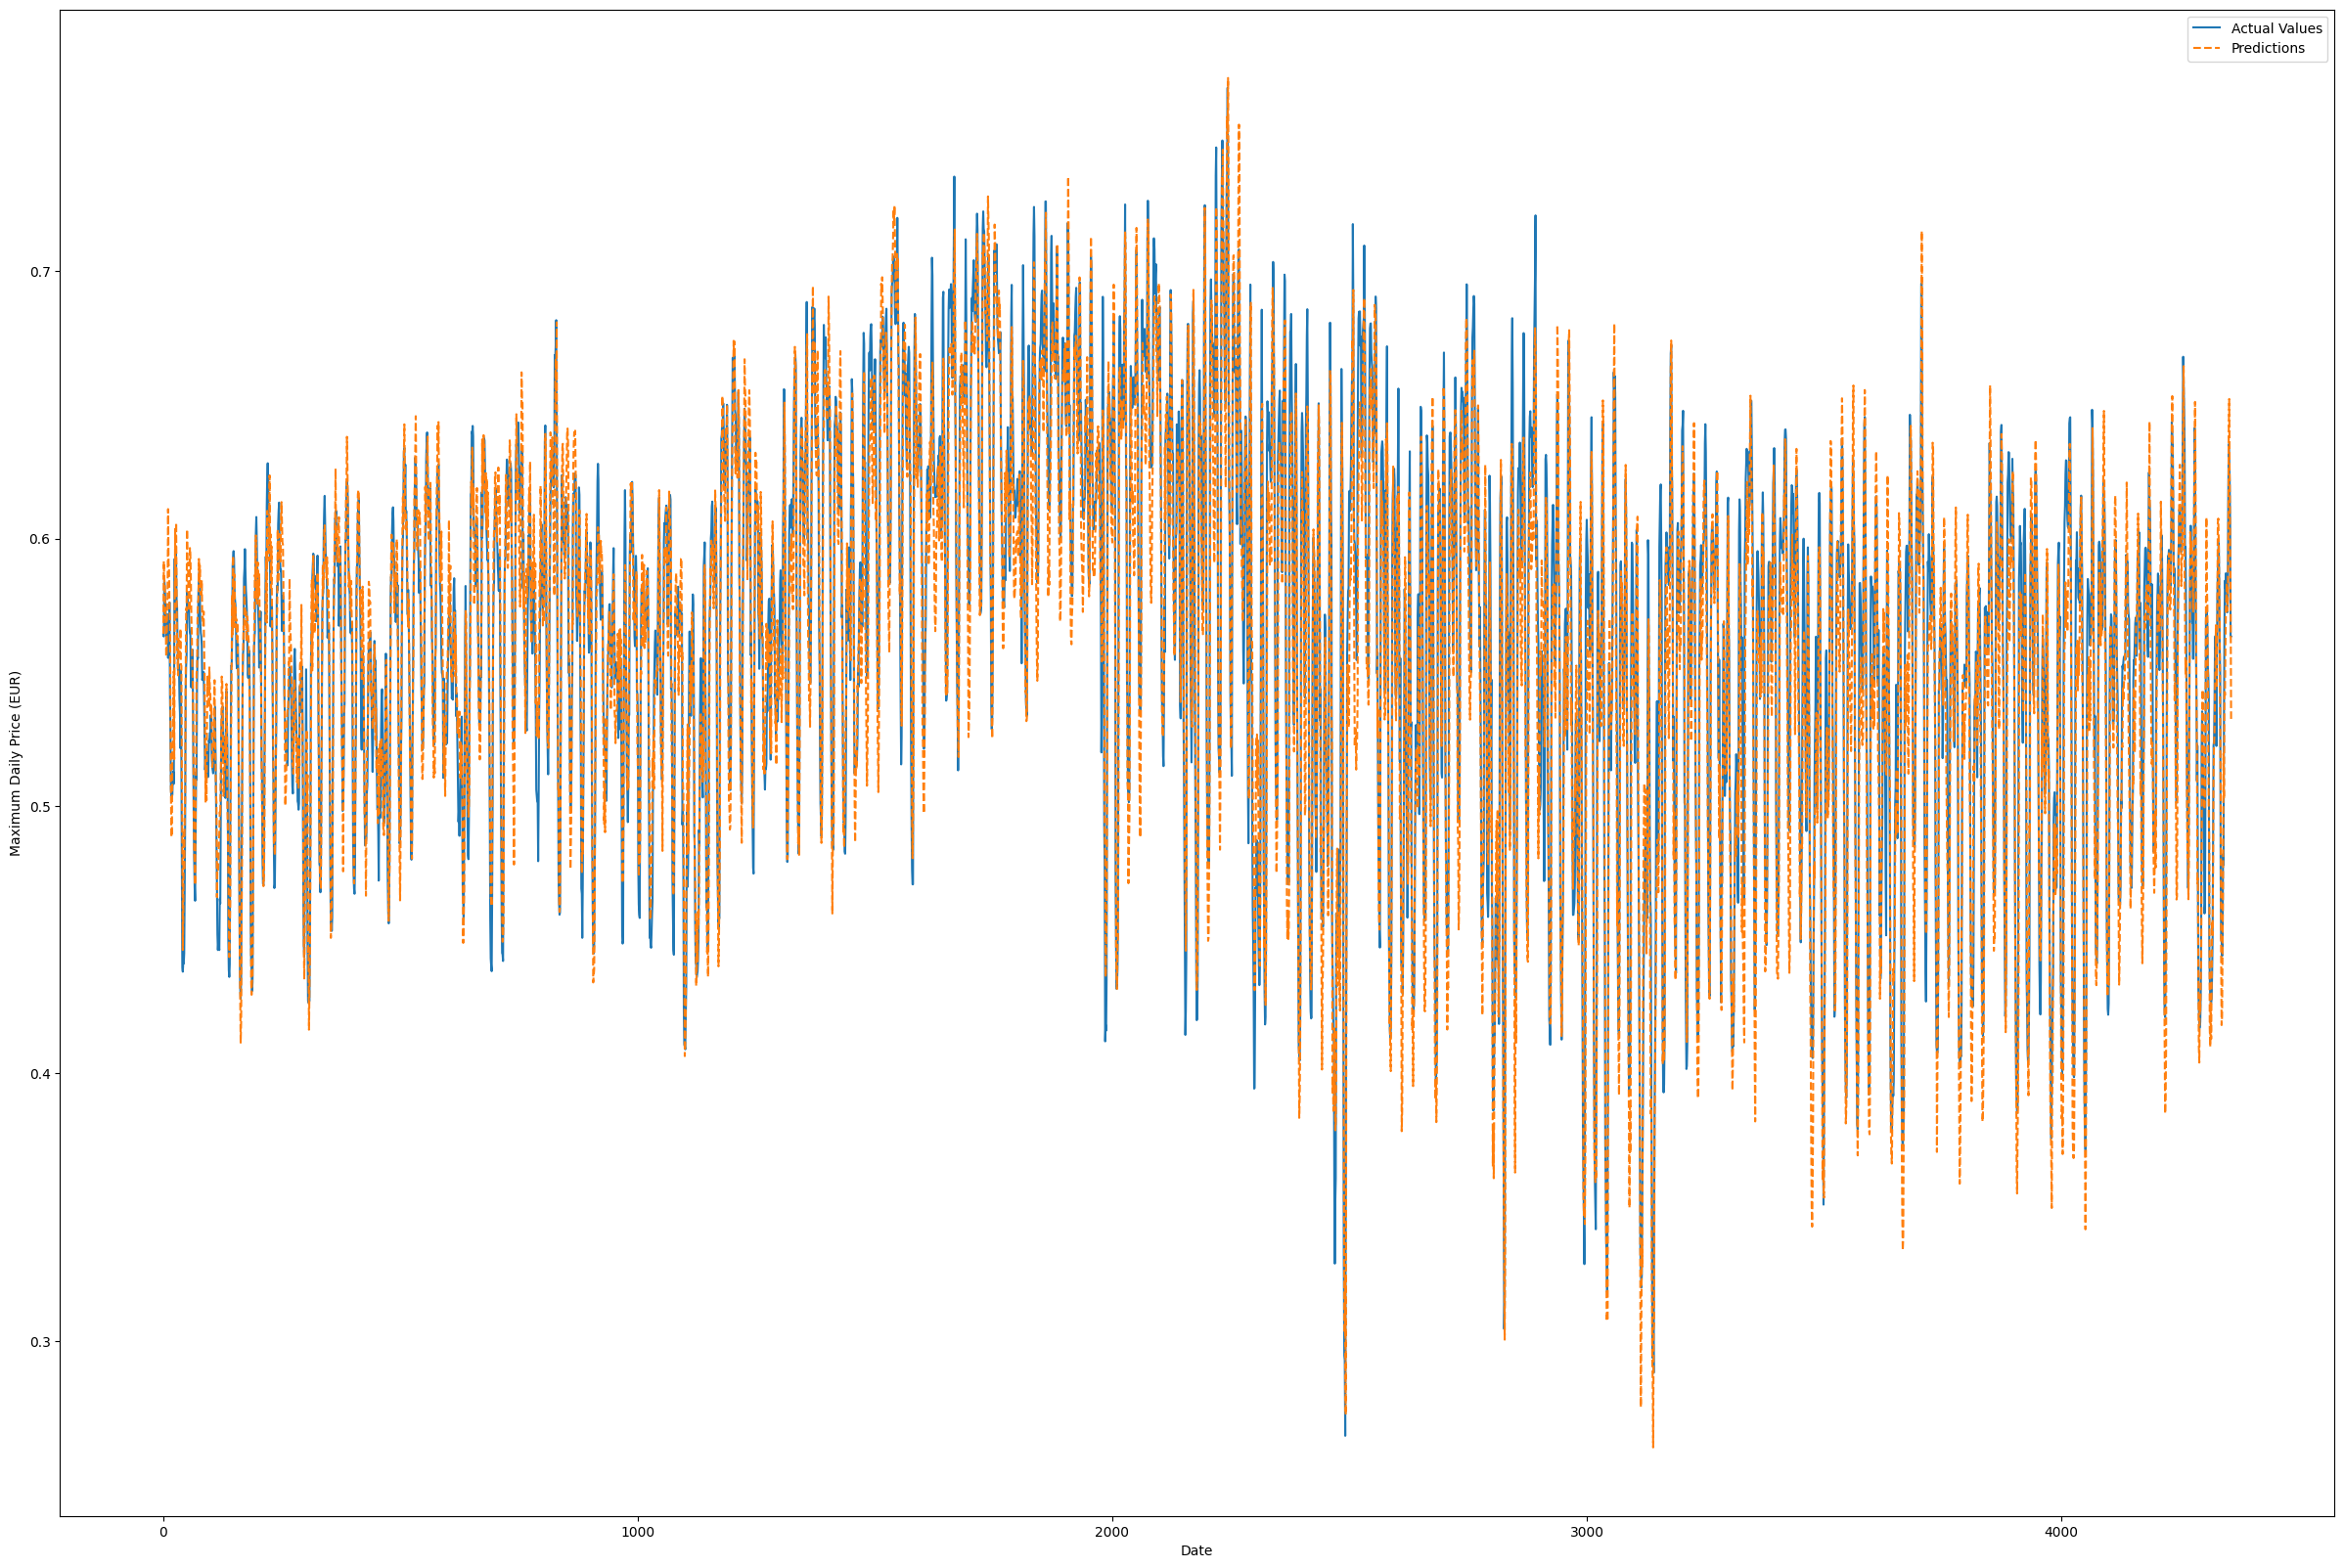

In [ ]:
plotPredictions(pred_mlp)

### Hyperparameter Tuning

#### Rolling Forecast Origin K-Folds Cross Validation

 In time series, cross-validation becomes more difficult since leaving out an observation does not remove all the associated information due to the correlations with others and by shuffling past and future data, the model learns the future that it is not supposed to know. This means that we cannot rely on techniques such as standard LOOCV and K-folds.

Here, we have designed a cross-validation setup that splits the training data into k folds. It starts by taking the first fold as the training set and the second as the test set. Then at the next iteration takes the first and second folds as the training set and the third as the test set and so on. This preserves the temporal structure and dependencies of the data, while allowing model validation.

Source: https://robjhyndman.com/hyndsight/crossvalidation/#cross-validation-for-time-series



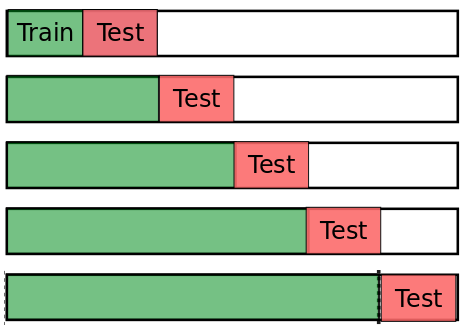

It should be noted that this was originally designed for X_train, X_test, y_train, y_test which have time dependencies, rather than data processed using tensor_slices which is shuffled. However, there is still some benefit in using it to improve generalisability, so it is left in.



In [ ]:
def rolling_origin_Kfolds(X_train, X_valid, y_train, y_valid, k):
  k = k+1
  p = math.ceil(len(X_train)/k)

  for i in range(1,k):
    idx = p*i
    cv_train = tf.data.Dataset.from_tensor_slices((X_train[:idx], y_train[:idx])).cache().shuffle(buffer_size).batch(batch_size).prefetch(1)

    cv_validation = tf.data.Dataset.from_tensor_slices((X_valid[:idx], y_valid[:idx])).batch(batch_size).prefetch(1)

    yield cv_train, cv_validation


In [ ]:
# visualise cv train/test lengths

cv_rolling = rolling_origin_Kfolds(X_train, X_valid, y_train, y_valid, k = 3)

i = 0
for cv_train, cv_validation in cv_rolling:
  print(f'Fold:\t{i+1}')
  print(f'CV Train:\t{len(cv_train)}')
  print(f'CV validation:\t{len(cv_validation)}')
  print("-----------")
  i += 1

Fold:	1
CV Train:	137
CV validation:	91
-----------
Fold:	2
CV Train:	274
CV validation:	91
-----------
Fold:	3
CV Train:	411
CV validation:	91
-----------


We utilise the Optuna package to perform bayesian optimisation on the build_model function in order to find the best hyperparameters. This is an appropriate tool for this problem since there are many hyperparameters and hence a large parameter search space.


In [ ]:
!pip install optuna
import optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.4 MB/s eta 0:00:00


In [ ]:
def objective(trial):
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid'])
    ff_dim1 = trial.suggest_int('ff_dim1', 32, 512, log=True)
    ff_dim2 = trial.suggest_int('ff_dim2', 32, 512, log=True)
    ff_dim3 = trial.suggest_int('ff_dim3', 32, 512, log=True)
    ff_dim4 = trial.suggest_int('ff_dim4', 32, 512, log=True)
    ff_dim5 = trial.suggest_int('ff_dim5', 32, 512, log=True)
    dropout_dim = trial.suggest_float('dropout_dim', 0.05, 0.5, log=True)
    batch_size = 1 #trial.suggest_int('batch_size', 1, 64, log=True)
    epochs = 1 #trial.suggest_int('epochs', 1, 32, log=True)

    cv_scores = []
    for cv_train, cv_validation in rolling_origin_Kfolds(X_train, X_valid, y_train, y_valid, k):
        model = build_model_mlp(input_shape=input_shape,
                                activation=activation,
                                ff_dim1=ff_dim1,
                                ff_dim2=ff_dim2,
                                ff_dim3=ff_dim3,
                                ff_dim4=ff_dim4,
                                ff_dim5=ff_dim5,
                                dropout_dim=dropout_dim)

        model.compile(loss=loss, optimizer=optimizer, metrics=metric)
        model.fit(cv_train, epochs=epochs, batch_size=batch_size, validation_data=cv_validation)
        y_pred = model.predict(X_test)
        rmse = sqrt(mean_squared_error(y_test_inv, scaler_y.inverse_transform(y_pred)))
        cv_scores.append(rmse)

    # Return the average cross-validation score
    return np.mean(cv_scores)

In [ ]:
np.random.seed(42)

k = 3 # number of folds

# Set up Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20,  n_jobs = -1)

# best parameters
best_params = study.best_params
best_score = study.best_value

print("Best hyperparameters:", best_params)
print("Best cross-validation score (average accuracy):", best_score)


[I 2023-12-13 10:03:30,680] A new study created in memory with name: no-name-b9af1033-441f-4e93-8a91-491886a53e98


137/411 [=========>....................] - ETA: 22s - loss: 1.3943 - root_mean_squared_error: 0.2135 - mae: 0.5446

[I 2023-12-13 10:06:04,228] Trial 1 finished with value: 7.627923643192081 and parameters: {'activation': 'relu', 'ff_dim1': 179, 'ff_dim2': 57, 'ff_dim3': 167, 'ff_dim4': 84, 'ff_dim5': 215, 'dropout_dim': 0.1393824192077052}. Best is trial 1 with value: 7.627923643192081.


 55/137 [===========>..................] - ETA: 1s

[I 2023-12-13 10:06:28,791] Trial 0 finished with value: 16.931925903536314 and parameters: {'activation': 'tanh', 'ff_dim1': 38, 'ff_dim2': 67, 'ff_dim3': 204, 'ff_dim4': 349, 'ff_dim5': 160, 'dropout_dim': 0.34457340933363867}. Best is trial 1 with value: 7.627923643192081.


263/411 [==================>...........] - ETA: 7s - loss: 0.1675 - root_mean_squared_error: 0.3538 - mae: 0.2885

[I 2023-12-13 10:07:56,342] Trial 2 finished with value: 10.773560912048026 and parameters: {'activation': 'relu', 'ff_dim1': 80, 'ff_dim2': 178, 'ff_dim3': 444, 'ff_dim4': 98, 'ff_dim5': 235, 'dropout_dim': 0.1702646994015372}. Best is trial 1 with value: 7.627923643192081.


 58/137 [===========>..................] - ETA: 0s

[I 2023-12-13 10:08:24,020] Trial 3 finished with value: 19.780808959574387 and parameters: {'activation': 'sigmoid', 'ff_dim1': 231, 'ff_dim2': 300, 'ff_dim3': 292, 'ff_dim4': 156, 'ff_dim5': 39, 'dropout_dim': 0.3326492035653448}. Best is trial 1 with value: 7.627923643192081.


137/137 [==============================] - 5s 30ms/step


[I 2023-12-13 10:10:15,648] Trial 4 finished with value: 11.924691748897237 and parameters: {'activation': 'tanh', 'ff_dim1': 67, 'ff_dim2': 42, 'ff_dim3': 338, 'ff_dim4': 184, 'ff_dim5': 262, 'dropout_dim': 0.1439591441216155}. Best is trial 1 with value: 7.627923643192081.


306/411 [=====================>........] - ETA: 7s - loss: 0.0586 - root_mean_squared_error: 0.1166 - mae: 0.1486

[I 2023-12-13 10:12:02,726] Trial 5 finished with value: 11.17626638240811 and parameters: {'activation': 'relu', 'ff_dim1': 60, 'ff_dim2': 300, 'ff_dim3': 184, 'ff_dim4': 512, 'ff_dim5': 421, 'dropout_dim': 0.09712037327631418}. Best is trial 1 with value: 7.627923643192081.


137/137 [==============================] - 2s 9ms/step


[I 2023-12-13 10:12:15,829] Trial 6 finished with value: 19.652419377560317 and parameters: {'activation': 'sigmoid', 'ff_dim1': 207, 'ff_dim2': 458, 'ff_dim3': 39, 'ff_dim4': 61, 'ff_dim5': 51, 'dropout_dim': 0.2958277996936821}. Best is trial 1 with value: 7.627923643192081.


125/274 [============>.................] - ETA: 10s - loss: 0.0159 - root_mean_squared_error: 0.0863 - mae: 0.0927

[I 2023-12-13 10:12:46,315] Trial 7 finished with value: 13.626514962367063 and parameters: {'activation': 'relu', 'ff_dim1': 55, 'ff_dim2': 93, 'ff_dim3': 52, 'ff_dim4': 77, 'ff_dim5': 106, 'dropout_dim': 0.05208428442955759}. Best is trial 1 with value: 7.627923643192081.


137/137 [==============================] - 1s 10ms/step


[I 2023-12-13 10:13:42,660] Trial 8 finished with value: 7.872566830022879 and parameters: {'activation': 'relu', 'ff_dim1': 367, 'ff_dim2': 94, 'ff_dim3': 84, 'ff_dim4': 487, 'ff_dim5': 59, 'dropout_dim': 0.34747613916670644}. Best is trial 1 with value: 7.627923643192081.


346/411 [========================>.....] - ETA: 1s - loss: 0.0572 - root_mean_squared_error: 0.2189 - mae: 0.1234

[I 2023-12-13 10:14:24,141] Trial 9 finished with value: 18.058470680089663 and parameters: {'activation': 'sigmoid', 'ff_dim1': 47, 'ff_dim2': 438, 'ff_dim3': 212, 'ff_dim4': 97, 'ff_dim5': 171, 'dropout_dim': 0.11128320260974471}. Best is trial 1 with value: 7.627923643192081.


 68/137 [=============>................] - ETA: 1s - loss: 0.0237 - root_mean_squared_error: 0.1130 - mae: 0.1099

[I 2023-12-13 10:14:30,242] Trial 10 finished with value: 8.226343555676403 and parameters: {'activation': 'tanh', 'ff_dim1': 48, 'ff_dim2': 210, 'ff_dim3': 59, 'ff_dim4': 58, 'ff_dim5': 128, 'dropout_dim': 0.10211958233579667}. Best is trial 1 with value: 7.627923643192081.


194/411 [=============>................] - ETA: 6s - loss: 0.0196 - root_mean_squared_error: 0.1057 - mae: 0.1068

[I 2023-12-13 10:15:04,280] Trial 11 finished with value: 10.064062731660005 and parameters: {'activation': 'relu', 'ff_dim1': 152, 'ff_dim2': 39, 'ff_dim3': 106, 'ff_dim4': 33, 'ff_dim5': 92, 'dropout_dim': 0.05979673540061683}. Best is trial 1 with value: 7.627923643192081.


 67/137 [=============>................] - ETA: 0s

[I 2023-12-13 10:15:20,415] Trial 12 finished with value: 11.006201966889378 and parameters: {'activation': 'relu', 'ff_dim1': 494, 'ff_dim2': 34, 'ff_dim3': 100, 'ff_dim4': 42, 'ff_dim5': 68, 'dropout_dim': 0.4729188981737389}. Best is trial 1 with value: 7.627923643192081.


137/137 [==============================] - 2s 13ms/step


[I 2023-12-13 10:16:27,171] Trial 13 finished with value: 8.3862904620432 and parameters: {'activation': 'relu', 'ff_dim1': 504, 'ff_dim2': 75, 'ff_dim3': 112, 'ff_dim4': 241, 'ff_dim5': 67, 'dropout_dim': 0.2183441832452996}. Best is trial 1 with value: 7.627923643192081.


  1/274 [..............................] - ETA: 13:46 - loss: 0.2467 - root_mean_squared_error: 0.0689 - mae: 0.4692

[I 2023-12-13 10:17:18,389] Trial 14 finished with value: 6.4330575858757975 and parameters: {'activation': 'relu', 'ff_dim1': 428, 'ff_dim2': 77, 'ff_dim3': 79, 'ff_dim4': 227, 'ff_dim5': 437, 'dropout_dim': 0.21385171644239764}. Best is trial 14 with value: 6.4330575858757975.


 12/411 [..............................] - ETA: 21s - loss: 0.3562 - root_mean_squared_error: 0.2112 - mae: 0.4741

[I 2023-12-13 10:19:15,440] Trial 15 finished with value: 8.22581302578043 and parameters: {'activation': 'relu', 'ff_dim1': 313, 'ff_dim2': 118, 'ff_dim3': 79, 'ff_dim4': 262, 'ff_dim5': 464, 'dropout_dim': 0.21552060926092587}. Best is trial 14 with value: 6.4330575858757975.


137/137 [==============================] - 1s 6ms/step


[I 2023-12-13 10:20:22,549] Trial 17 finished with value: 8.790644479257859 and parameters: {'activation': 'relu', 'ff_dim1': 127, 'ff_dim2': 52, 'ff_dim3': 142, 'ff_dim4': 130, 'ff_dim5': 304, 'dropout_dim': 0.07390355472682729}. Best is trial 14 with value: 6.4330575858757975.


 85/274 [========>.....................] - ETA: 11s - loss: 0.0264 - root_mean_squared_error: 0.1327 - mae: 0.1047

[I 2023-12-13 10:20:42,055] Trial 16 finished with value: 11.709511923222507 and parameters: {'activation': 'relu', 'ff_dim1': 116, 'ff_dim2': 57, 'ff_dim3': 143, 'ff_dim4': 239, 'ff_dim5': 431, 'dropout_dim': 0.20079346283755034}. Best is trial 14 with value: 6.4330575858757975.


410/411 [============================>.] - ETA: 0s - loss: 0.1138 - root_mean_squared_error: 0.3070 - mae: 0.1342

[I 2023-12-13 10:21:54,787] Trial 18 finished with value: 10.645972837281077 and parameters: {'activation': 'relu', 'ff_dim1': 104, 'ff_dim2': 60, 'ff_dim3': 146, 'ff_dim4': 216, 'ff_dim5': 347, 'dropout_dim': 0.14881822266945788}. Best is trial 14 with value: 6.4330575858757975.


137/137 [==============================] - 1s 7ms/step


[I 2023-12-13 10:22:02,468] Trial 19 finished with value: 9.3915105666333 and parameters: {'activation': 'tanh', 'ff_dim1': 232, 'ff_dim2': 146, 'ff_dim3': 32, 'ff_dim4': 113, 'ff_dim5': 300, 'dropout_dim': 0.14884716826500324}. Best is trial 14 with value: 6.4330575858757975.


Best hyperparameters: {'activation': 'relu', 'ff_dim1': 428, 'ff_dim2': 77, 'ff_dim3': 79, 'ff_dim4': 227, 'ff_dim5': 437, 'dropout_dim': 0.21385171644239764}
Best cross-validation score (average accuracy): 6.4330575858757975


In [ ]:
np.random.seed(42)
mlp_optim = build_model_mlp(input_shape = input_shape, activation = best_params['activation'], ff_dim1 = best_params['ff_dim1'], ff_dim2 = best_params['ff_dim2'], ff_dim3 = best_params['ff_dim3'], ff_dim4 = best_params['ff_dim4'], ff_dim5 = best_params['ff_dim5'], dropout_dim = best_params['dropout_dim'])
mlp_optim.compile(optimizer = optimizer, loss = loss, metrics = metric)
mlp_optim_history = mlp_optim.fit(train, epochs = 10, validation_data=validation)

Epoch 1/10
548/548 [==============================] - 37s 65ms/step - loss: 0.0062 - root_mean_squared_error: 0.0771 - mae: 0.0518 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0445 - val_mae: 0.0339
Epoch 2/10
548/548 [==============================] - 36s 65ms/step - loss: 0.0019 - root_mean_squared_error: 0.0433 - mae: 0.0333 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0488 - val_mae: 0.0377
Epoch 3/10
548/548 [==============================] - 35s 64ms/step - loss: 0.0015 - root_mean_squared_error: 0.0389 - mae: 0.0299 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0357 - val_mae: 0.0275
Epoch 4/10
548/548 [==============================] - 35s 64ms/step - loss: 0.0013 - root_mean_squared_error: 0.0358 - mae: 0.0275 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0402 - val_mae: 0.0318
Epoch 5/10
548/548 [==============================] - 36s 65ms/step - loss: 0.0012 - root_mean_squared_error: 0.0340 - mae: 0.0262 - val_loss: 0.0012 - val_root_mean_squared_er

In [ ]:
np.random.seed(42)
pred_mlp_optim = mlp_optim.predict(X_test)
rmse_mlp_optim = sqrt(mean_squared_error(y_test_inv, scaler_y.inverse_transform(pred_mlp_optim)))

print(f'RMSE of hour-ahead electricity price MLP forecast: {round(rmse_mlp_optim, 3)}')

137/137 [==============================] - 6s 39ms/step
RMSE of hour-ahead electricity price MLP forecast: 2.559


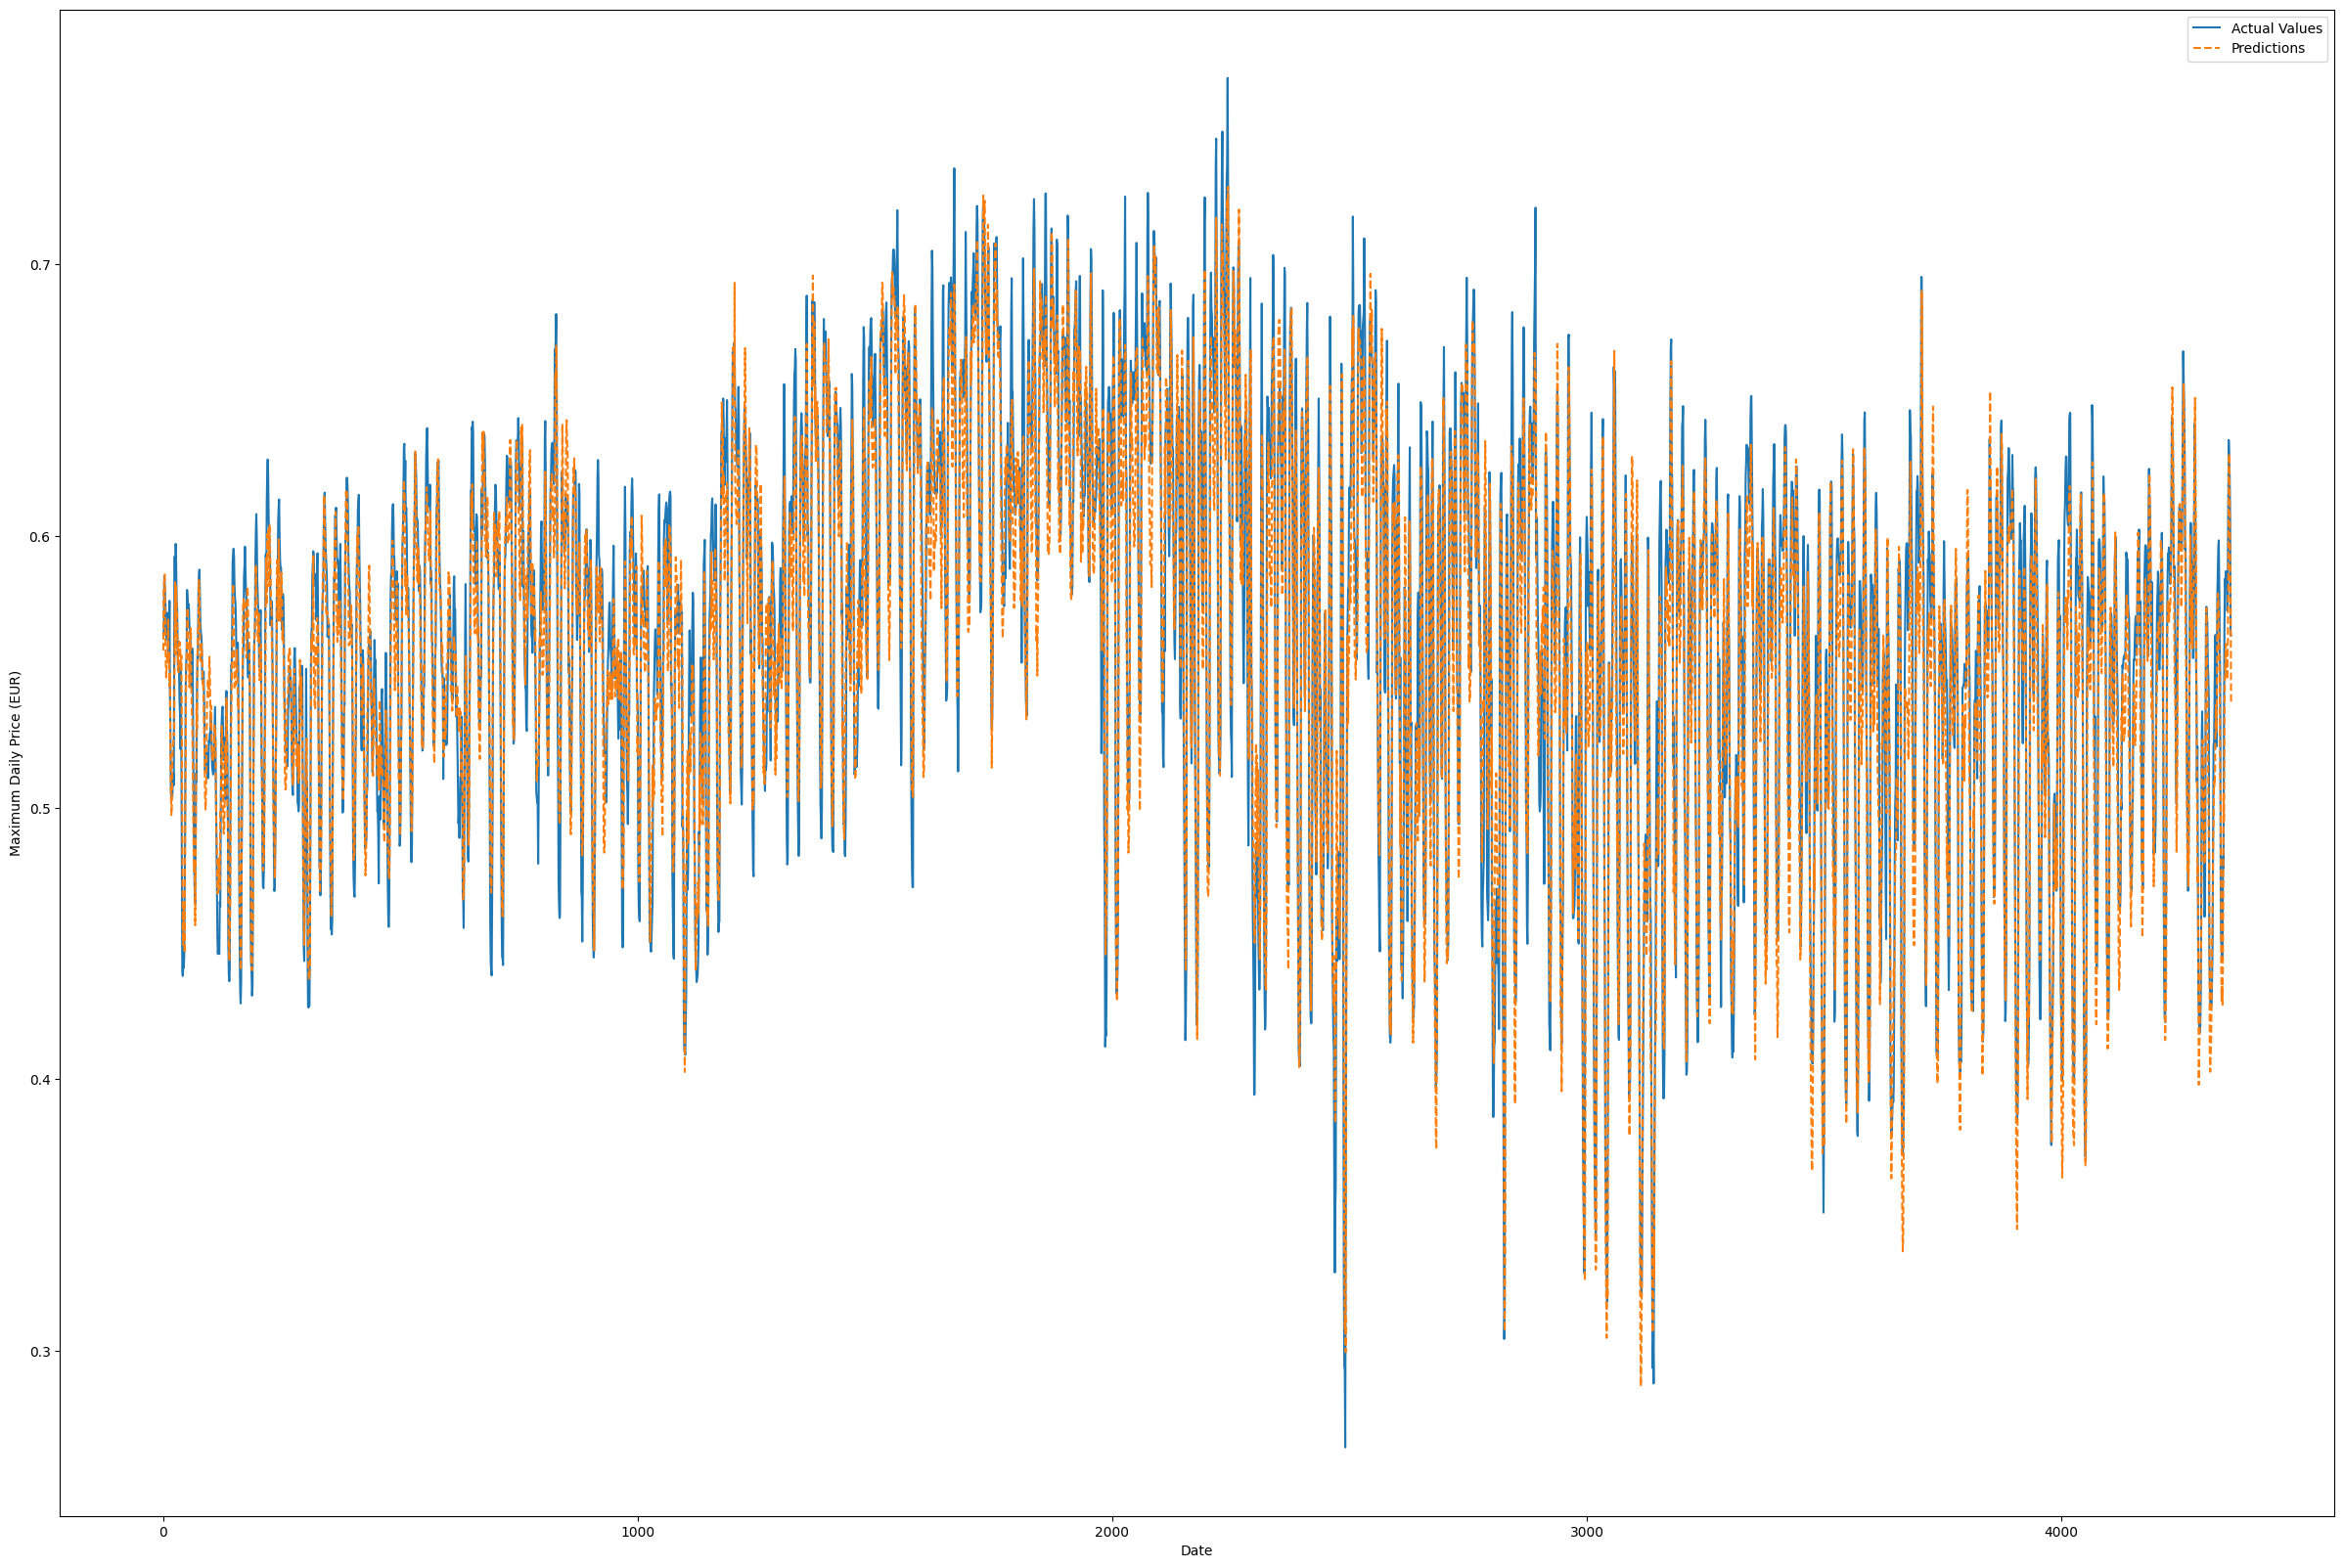

In [ ]:
plotPredictions(pred_mlp_optim)

In [ ]:
mlp_optim.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDi  (None, 24, 428)           7704      
 stributed)                                                      
                                                                 
 time_distributed_9 (TimeDi  (None, 24, 77)            33033     
 stributed)                                                      
                                                                 
 time_distributed_10 (TimeD  (None, 24, 79)            6162      
 istributed)                                                     
                                                                 
 time_distributed_11 (TimeD  (None, 24, 227)           18160     
 istributed)                                                     
                                                                 
 flatten_10 (Flatten)        (None, 5448)             

Note that we have not tuned every single possible hyperparameter that we could and that we do not optimise the batch size or epochs and limit number of trials and the number of folds to save on compute time.


After performing hyperparameter tuning, one can observe an improvement in the performance of this model. From the graph, the predictions of the tuned model follow slightly more closely to the real values and the RMSE has been reduce. While this is a worthwhile procedure to implement, due to time constraints there is room for improvement and a much more rigorous and intensive search could have been performed.

### Performance Optimisation

Here, we take advantage of the 'n_jobs' argument in the optuna algorithm to parallelise this computationally costly process and hence speed-up the code. This works by distributing the computation of each trial (iteration) to a different core, up to the number of cores available, and each trial is computed in parallel. Source: https://medium.com/optuna/parallel-hyperparameter-tuning-with-optuna-and-kubeflow-pipelines-4ef05ce614ae


## Other Misc.

Many of our models did not perform as well as they could have if we had more time available to improve them. This could be due to several reasons including:

Limited Feature Engineering: We could have performed more feature generation that encode seasonal trends, such as creating features for "business hours", "weekends", etc

Predicting the energy price for the 25th hour based on only the previous 24 hours might not be sufficient to capture complex relationships and trends that develop over longer periods.

Model Complexity: Some neural network architectures might have been overly complex, leading to overfitting and a poor generalisation performance on unseen data and some may not have been complex enough to capture the complex relationships and trends in the data.

# Introduction

In this project, we explore the performance of deep neural network architectures to forecast time series energy price data. We investigate Convolutional Neural Networks (CNN), Time Distributed Feed-Forward Neural Networks, Long Short-term Memory Recurrent Neural Networks (LSTM) and Stacked Neural Networks. In addition, perform time series analysis on our data set and discuss some of the theoretical aspects of our approaches in each relevant section.